# 배달의 민족 댓글 데이터 분석
제출일: 24/12/16
제출파일: 주피터노트북 또는 보고서 파일
제출경로: 구글 드라이브 > 프로젝트 > 12월 미니 프로젝트 > 각자 조 폴더
각자 제출

### 요구사항
- score를 기준으로 댓글의 긍정 / 부정 분류
    - 긍정: 4~5
    - 긍정2: 4~5 및 "불편"이라는 단어를 포함하지 않는 리뷰
    - 부정: 1~3
    - 댓글의 긍정 / 부정에 대한 분석 진행
- 데이터 불러오기
- 댓글의 긍정 / 부정을 나타내는 reaction열 만들기
- reaction 컬럼 bar 그래프 그리기
- 형태소 분석기를 사용해서 긍정 / 부정별 워드 클라우드 그리기
- 긍정 / 부정별 장바구니 분석 및 네트워크 그림 그리기
- 댓글별 유사도 계산해보고 해석해보기

In [171]:
import pandas as pd
from matplotlib import pyplot as plt
import koreanize_matplotlib
import seaborn as sns

### 데이터 불러오기

In [172]:
## todo: 빈도수 분석, 네트워크 분석, 댓글별 유사도 분석

reviews = pd.read_csv('data/배달의민족댓글2.csv', index_col=0, encoding="utf8")
print(reviews.head())
print(reviews.shape)

                                                text  score
0                                                NaN      4
1                                                NaN      5
2                                                NaN      1
3  배달의민족 주문시 리뷰를 자주 참고하는 편입니다. 한가지 건의사항이 있다면 최신순,...      4
4  내가 주문했던 과거목록에서도 검색기능이 있었으면 좋겠어요.. 분명 이 가게에 시킨 ...      5
(1003, 2)


### 데이터 전처리

In [173]:
reviews.dropna(inplace=True)
reviews.reset_index(drop=True, inplace=True)
reviews.head()

,text,score
0,"배달의민족 주문시 리뷰를 자주 참고하는 편입니다. 한가지 건의사항이 있다면 최신순,...",4
1,내가 주문했던 과거목록에서도 검색기능이 있었으면 좋겠어요.. 분명 이 가게에 시킨 ...,5
2,"검색 화면에서 전체/배달/포장 탭 중 배달 탭을 스크롤 내리면서 볼 때, 아래로 스...",1
3,배달팁 낮은 순으로 정렬하면 0~4000원 이런식으로 된 가게가 가장 위로 올라옵니...,2
4,최근 업데이트가 안드로이드5사양 정도에서는 안되는것 같습니다.. 배민 어플 실행시 ...,3


In [174]:
import re

# reviews['댓글'] = reviews['댓글'].map(lambda x: x.encode('cp949', 'ignore').decode('cp949'))  # 댓글 이모지 제거
# reviews['review'] = reviews['댓글'].map(lambda x: re.sub("[^가-힣\\s+\\d+]", "", x))
reviews['review'] = reviews['text'].map(lambda x: re.sub("[^\\w\\s]", " ", x))
reviews['review'] = reviews['review'].map(lambda x: re.sub("\\s+", " ", x))  # 1개 이상 반복되는 공백을 1개의 공백으로 치환
reviews['s_len_ori'] = reviews['text'].map(lambda x: len(str(x)))  # 원본 리뷰 글자 수 컬럼 추가
reviews['s_len'] = reviews['review'].map(lambda x: len(str(x)))  # 리뷰 글자 수 컬럼 추가
reviews['reaction'] = "N"
reviews.loc[reviews['score'] >= 4, 'reaction'] = "P"

reviews.head()


,text,score,review,s_len_ori,s_len,reaction
0,"배달의민족 주문시 리뷰를 자주 참고하는 편입니다. 한가지 건의사항이 있다면 최신순,...",4,배달의민족 주문시 리뷰를 자주 참고하는 편입니다 한가지 건의사항이 있다면 최신순 별...,227,223,P
1,내가 주문했던 과거목록에서도 검색기능이 있었으면 좋겠어요.. 분명 이 가게에 시킨 ...,5,내가 주문했던 과거목록에서도 검색기능이 있었으면 좋겠어요 분명 이 가게에 시킨 기억...,175,168,P
2,"검색 화면에서 전체/배달/포장 탭 중 배달 탭을 스크롤 내리면서 볼 때, 아래로 스...",1,검색 화면에서 전체 배달 포장 탭 중 배달 탭을 스크롤 내리면서 볼 때 아래로 스크...,229,224,N
3,배달팁 낮은 순으로 정렬하면 0~4000원 이런식으로 된 가게가 가장 위로 올라옵니...,2,배달팁 낮은 순으로 정렬하면 0 4000원 이런식으로 된 가게가 가장 위로 올라옵니...,196,190,N
4,최근 업데이트가 안드로이드5사양 정도에서는 안되는것 같습니다.. 배민 어플 실행시 ...,3,최근 업데이트가 안드로이드5사양 정도에서는 안되는것 같습니다 배민 어플 실행시 업데...,250,244,N


### 탐색적 데이터 분석

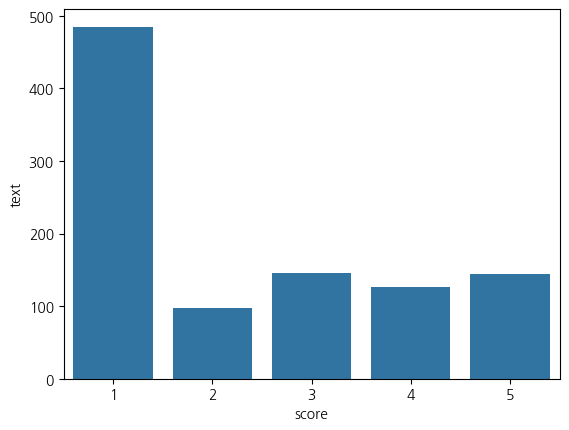

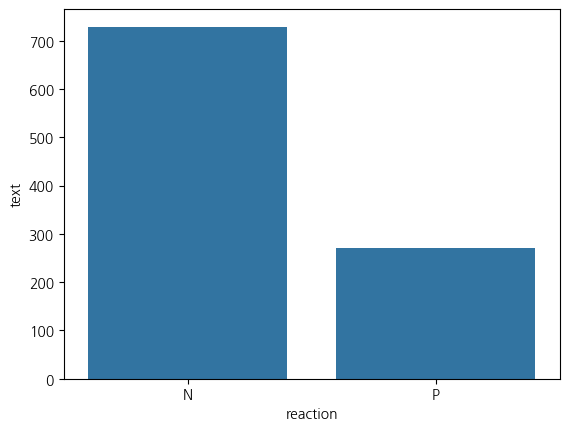

In [175]:
# 점수 분포 확인
score_count = reviews.groupby("score").count()["text"]
sns.barplot(score_count)
plt.show()

# 긍정 / 부정 분포 확인
score_count = reviews.groupby("reaction").count()["text"]
sns.barplot(score_count)
plt.show()


In [176]:
from konlpy.tag import Kkma

kkma = Kkma()

# 리뷰 명사 추출
reviews['nouns'] = reviews['review'].apply(lambda x: kkma.nouns(x))
reviews.head()



,text,score,review,s_len_ori,s_len,reaction,nouns
0,"배달의민족 주문시 리뷰를 자주 참고하는 편입니다. 한가지 건의사항이 있다면 최신순,...",4,배달의민족 주문시 리뷰를 자주 참고하는 편입니다 한가지 건의사항이 있다면 최신순 별...,227,223,P,"[배달, 민족, 주문, 주문시, 시, 리뷰, 편, 가지, 건의, 건의사항, 사항, ..."
1,내가 주문했던 과거목록에서도 검색기능이 있었으면 좋겠어요.. 분명 이 가게에 시킨 ...,5,내가 주문했던 과거목록에서도 검색기능이 있었으면 좋겠어요 분명 이 가게에 시킨 기억...,175,168,P,"[내가, 주문, 과거, 과거목록, 목록, 검색, 검색기능, 기능, 분, 분명, 명,..."
2,"검색 화면에서 전체/배달/포장 탭 중 배달 탭을 스크롤 내리면서 볼 때, 아래로 스...",1,검색 화면에서 전체 배달 포장 탭 중 배달 탭을 스크롤 내리면서 볼 때 아래로 스크...,229,224,N,"[검색, 화면, 전체, 배달, 포장, 탭, 중, 스크롤, 때, 아래, 왼쪽, 오른쪽..."
3,배달팁 낮은 순으로 정렬하면 0~4000원 이런식으로 된 가게가 가장 위로 올라옵니...,2,배달팁 낮은 순으로 정렬하면 0 4000원 이런식으로 된 가게가 가장 위로 올라옵니...,196,190,N,"[배달, 배달팁, 팁, 낮, 순, 정렬, 0, 4000, 4000원, 원, 식, 가..."
4,최근 업데이트가 안드로이드5사양 정도에서는 안되는것 같습니다.. 배민 어플 실행시 ...,3,최근 업데이트가 안드로이드5사양 정도에서는 안되는것 같습니다 배민 어플 실행시 업데...,250,244,N,"[최근, 업데이트, 드로, 드로이드5사, 이드, 5, 사, 정도, 배, 배민, 민,..."


In [177]:
from collections import Counter
import pprint

# 전체 단어 워드크라우드 시각화
word_list = sum(list(reviews["nouns"]), [])
print(word_list)
counter = Counter(word_list)
counter_mc = dict(counter.most_common(30))
pprint.pp(counter_mc)

['배달', '민족', '주문', '주문시', '시', '리뷰', '편', '가지', '건의', '건의사항', '사항', '최신', '최신순', '순', '별', '별점순', '점', '뿐', '제가', '메뉴', '특정', '확인', '수', '기능', '메뉴검색', '검색', '검색기능', '필요', '주', '주문수', '문수', '드래그', '시간', '소요', '비효율', '발생', '긍정적', '검토', '주심', '내가', '주문', '과거', '과거목록', '목록', '검색', '검색기능', '기능', '분', '분명', '명', '가게', '기억', '무엇', '메뉴', '검색가능', '가능', '예', '곱창', '을', '곱창목록', '리뷰', '리뷰창', '창', '뷰', '뷰보기', '보기', '거', '검색', '화면', '전체', '배달', '포장', '탭', '중', '스크롤', '때', '아래', '왼쪽', '오른쪽', '불편', '후', '마트', '뭐', '하나', '선택', '좌우', '건', '안', '번', '배달', '배달팁', '팁', '낮', '순', '정렬', '0', '4000', '4000원', '원', '식', '가게', '위', '지역', '추가', '별도', '체크', '결국', '5000', '5000원', '10', '10만원', '만', '이상', '0원', '데', '장난', '하나하나', '가격', '가격대별', '대별', '금액', '확인', '최근', '업데이트', '드로', '드로이드5사', '이드', '5', '사', '정도', '배', '배민', '민', '플', '실행', '실행시', '시', '하라', '업', '데이트', '진행', '열기', '무한', '무한반복', '반복', '수', '삭제', '설치', '환경', '환경설정등', '설정', '등', '증상', '분', '도', '글', '이번', '관련', '파일', '확인', '필요', '참고', '사양', '폰', '거', 

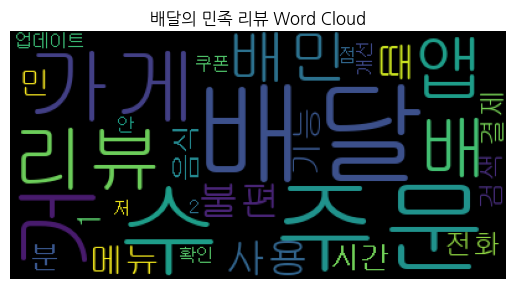

In [178]:
from wordcloud import WordCloud
wordcloud = WordCloud(
    font_path="C:/Windows/Fonts/NGULIM.TTF"
).generate_from_frequencies(counter_mc)
plt.imshow(wordcloud)
plt.title("배달의 민족 리뷰 Word Cloud")
plt.axis('off')
plt.show()

In [179]:
# # 고유명사 제거 테스트
# text_test = "배달의 민족 배달의민족 배달의  민족 배달의 속도가 빠른 민족"
# print(re.sub("배달의\\s*민족", " ", text_test))

In [180]:
# 단어 전처리
# 고유명사 제거(텍스트 수준), 한글자 제거(명사 수준), 불용어처리(명사 수준)
review_tmp = list(reviews['review'])
print(review_tmp[0])
review_tmp = [re.sub("배달의\\s*민족", " ", r) for r in review_tmp]
print(review_tmp[0])

# nouns_list = [kkma.nouns(r) for r in review_tmp]
# print(nouns_list[0])
stopwords = ["배민"]
nouns_list = []
for r in review_tmp:
    nouns_tmp = kkma.nouns(r)
    nouns_tmp = [n for n in nouns_tmp if len(n) > 1 and n not in stopwords]
    nouns_list.append(nouns_tmp)

reviews['nouns'] = nouns_list
reviews.head()



배달의민족 주문시 리뷰를 자주 참고하는 편입니다 한가지 건의사항이 있다면 최신순 별점순 뿐만아니라 제가 주문하고자하는 메뉴를 특정해서 그 메뉴의 리뷰만 확인할 수 있는 기능이 있으면 좋을 것 같습니다 메뉴검색 기능처럼 리뷰에서도 특정 메뉴 검색기능이 필요합니다 주문수가 많지않은 메뉴의 리뷰를 보기 위해서 드래그하느라 시간이 많이 소요되는 비효율이 발생합니다 긍정적으로 검토해주심 좋을 것 같습니다 
  주문시 리뷰를 자주 참고하는 편입니다 한가지 건의사항이 있다면 최신순 별점순 뿐만아니라 제가 주문하고자하는 메뉴를 특정해서 그 메뉴의 리뷰만 확인할 수 있는 기능이 있으면 좋을 것 같습니다 메뉴검색 기능처럼 리뷰에서도 특정 메뉴 검색기능이 필요합니다 주문수가 많지않은 메뉴의 리뷰를 보기 위해서 드래그하느라 시간이 많이 소요되는 비효율이 발생합니다 긍정적으로 검토해주심 좋을 것 같습니다 


,text,score,review,s_len_ori,s_len,reaction,nouns
0,"배달의민족 주문시 리뷰를 자주 참고하는 편입니다. 한가지 건의사항이 있다면 최신순,...",4,배달의민족 주문시 리뷰를 자주 참고하는 편입니다 한가지 건의사항이 있다면 최신순 별...,227,223,P,"[주문, 주문시, 리뷰, 가지, 건의, 건의사항, 사항, 최신, 최신순, 별점순, ..."
1,내가 주문했던 과거목록에서도 검색기능이 있었으면 좋겠어요.. 분명 이 가게에 시킨 ...,5,내가 주문했던 과거목록에서도 검색기능이 있었으면 좋겠어요 분명 이 가게에 시킨 기억...,175,168,P,"[내가, 주문, 과거, 과거목록, 목록, 검색, 검색기능, 기능, 분명, 가게, 기..."
2,"검색 화면에서 전체/배달/포장 탭 중 배달 탭을 스크롤 내리면서 볼 때, 아래로 스...",1,검색 화면에서 전체 배달 포장 탭 중 배달 탭을 스크롤 내리면서 볼 때 아래로 스크...,229,224,N,"[검색, 화면, 전체, 배달, 포장, 스크롤, 아래, 왼쪽, 오른쪽, 불편, 마트,..."
3,배달팁 낮은 순으로 정렬하면 0~4000원 이런식으로 된 가게가 가장 위로 올라옵니...,2,배달팁 낮은 순으로 정렬하면 0 4000원 이런식으로 된 가게가 가장 위로 올라옵니...,196,190,N,"[배달, 배달팁, 정렬, 4000, 4000원, 가게, 지역, 추가, 별도, 체크,..."
4,최근 업데이트가 안드로이드5사양 정도에서는 안되는것 같습니다.. 배민 어플 실행시 ...,3,최근 업데이트가 안드로이드5사양 정도에서는 안되는것 같습니다 배민 어플 실행시 업데...,250,244,N,"[최근, 업데이트, 드로, 드로이드5사, 이드, 정도, 실행, 실행시, 하라, 데이..."


['주문', '주문시', '리뷰', '가지', '건의', '건의사항', '사항', '최신', '최신순', '별점순', '제가', '메뉴', '특정', '확인', '기능', '메뉴검색', '검색', '검색기능', '필요', '주문수', '문수', '드래그', '시간', '소요', '비효율', '발생', '긍정적', '검토', '주심', '내가', '주문', '과거', '과거목록', '목록', '검색', '검색기능', '기능', '분명', '가게', '기억', '무엇', '메뉴', '검색가능', '가능', '곱창', '곱창목록', '리뷰', '리뷰창', '뷰보기', '보기', '검색', '화면', '전체', '배달', '포장', '스크롤', '아래', '왼쪽', '오른쪽', '불편', '마트', '하나', '선택', '좌우', '배달', '배달팁', '정렬', '4000', '4000원', '가게', '지역', '추가', '별도', '체크', '결국', '5000', '5000원', '10', '10만원', '이상', '0원', '장난', '하나하나', '가격', '가격대별', '대별', '금액', '확인', '최근', '업데이트', '드로', '드로이드5사', '이드', '정도', '실행', '실행시', '하라', '데이트', '진행', '열기', '무한', '무한반복', '반복', '삭제', '설치', '환경', '환경설정등', '설정', '증상', '이번', '관련', '파일', '확인', '필요', '참고', '사양', '핸드폰', '문제', '찜매장', '매장', '구분', '언제쯤', '개선', '독점', '해이', '건가요', '가요', '유명', '결제', '관련', '부분', '구성', '단순', '배민페', '사용', '사용절차', '절차', '양식', '중식', '카페', '업종별', '라도', '주세', 'ㄷ순', '이름', '재검색', '검색', '주문', '목록', '실행', '실행시', '로그', '로그인', '여부', '비회원', '회

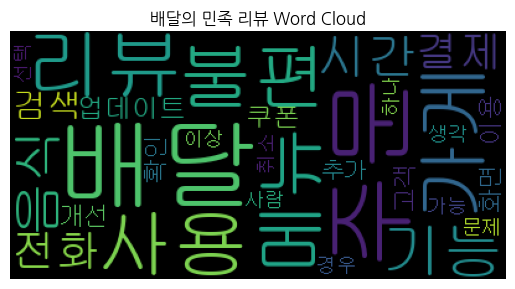

In [181]:
# 전체 단어 워드크라우드 시각화
word_list = sum(list(reviews["nouns"]), [])
print(word_list)
counter = Counter(word_list)
counter_mc = dict(counter.most_common(30))
# pprint.pp(counter_mc)

wordcloud = WordCloud(
    font_path="C:/Windows/Fonts/NGULIM.TTF"
).generate_from_frequencies(counter_mc)
plt.imshow(wordcloud)
plt.title("배달의 민족 리뷰 Word Cloud")
plt.axis('off')
plt.show()

### 긍정 부정 비교

#### WordCloud

In [190]:
# 긍정 단어 확인
sentence_word_list_p = list(reviews.loc[reviews["reaction"] == "P", "nouns"])
word_list_p = sum(sentence_word_list_p, [])  # unpacking

sentence_word_list_n = list(reviews.loc[reviews["reaction"] == "N", "nouns"])
word_list_n = sum(sentence_word_list_n, [])  # unpacking

print(word_list_p[:5], word_list_n[:5])

counter_p = Counter(word_list_p)
counter_p_mc = dict(counter_p.most_common(30))
print(counter_p_mc)

counter_n = Counter(word_list_n)
counter_n_mc = dict(counter_n.most_common(30))
print(counter_n_mc)

['주문', '주문시', '리뷰', '가지', '건의'] ['검색', '화면', '전체', '배달', '포장']
{'리뷰': 95, '배달': 91, '메뉴': 90, '주문': 89, '기능': 88, '사용': 73, '가게': 66, '음식': 58, '불편': 53, '검색': 50, '추가': 42, '개선': 38, '이용': 36, '사람': 33, '가지': 31, '선택': 31, '사항': 30, '결제': 30, '경우': 28, '생각': 28, '감사': 26, '편리': 26, '가능': 24, '시간': 23, '하나': 21, '확인': 20, '다양': 19, '어플': 18, '쿠폰': 17, '사진': 17}
{'배달': 291, '주문': 251, '가게': 141, '불편': 131, '사용': 116, '리뷰': 109, '시간': 105, '전화': 103, '업데이트': 95, '메뉴': 92, '쿠폰': 88, '결제': 85, '고객': 82, '확인': 77, '기능': 76, '화면': 75, '음식': 73, '문제': 69, '취소': 65, '이상': 63, '검색': 61, '개선': 61, '생각': 58, '오류': 58, '삭제': 55, '이용': 53, '로그': 52, '배달비': 52, '주세': 50, '센터': 50}


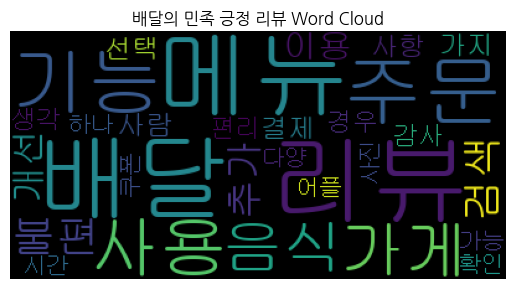

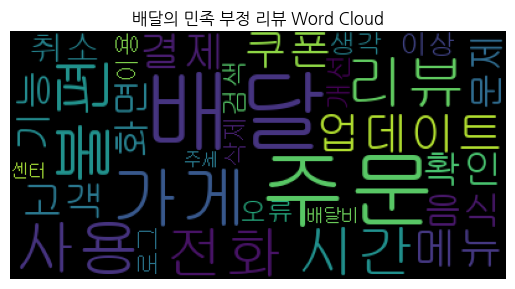

In [191]:
wordcloud_p = WordCloud(
    font_path="C:/Windows/Fonts/NGULIM.TTF"
).generate_from_frequencies(counter_p_mc)
plt.imshow(wordcloud_p)
plt.title("배달의 민족 긍정 리뷰 Word Cloud")
plt.axis('off')
plt.show()

wordcloud_n = WordCloud(
    font_path="C:/Windows/Fonts/NGULIM.TTF"
).generate_from_frequencies(counter_n_mc)
plt.imshow(wordcloud_n)
plt.title("배달의 민족 부정 리뷰 Word Cloud")
plt.axis('off')
plt.show()

In [192]:
# "불편"을 포함하는 긍정리뷰 확인
# print(reviews)
for i, s in reviews.iterrows():
    # print(type(s), s["score"])
    if '불편' in s["text"] and s["reaction"] == "P":
        print(s["score"], s["text"])


# 결론:
# 1. 부정적인 내용을 포함하지만 평점은 높게 준 리뷰들이 많음
# 2. 정말로 긍정적인 리뷰의 단어를 확인하고 싶다면 특정 키워드(ex. "불편")를 포함하는 리뷰를 제외하고 분석하는 것도 방법임


5 앱 실행시에 로그인 여부를 먼저 물어보고 비회원 이용을 선택할 경우, 혹은 나중에 입력 선택 후 주문 결제 시 받을 주소를 설정하는 것으로 순서를 변경하면 어떨까요? 저는 필요할 때만 어플을 설치해서 삭제, 설치를 자주 하는 편인데요! 다시 사용하려고 재설치하고 실행하면 회원정보에 주소 저장을 해놨음에도 어플 실행하면 로그인 여부 안 물어보고 주소를 다시 설정해야해서 불편해요 ㅜ.. 처음에 주소를 설정해도 주문할 때 어차피 로그인할 건데 시간이 매번 추가로 드네요 저같이 어플을 사용하는 사람이 많지는 않겠지만 혹시 굳이 주문도 하지 않은 상태에서 주소부터 설정하는 이유가 따로 있을까요? 수정하기 어려운 사항이라면 제가 그냥 어플을 삭제하지 않고 사용하겠지만 순서를 바꾸는 정도라면 어렵지 않을 거 같고 사용자로서 굳이 주소부터 설정할 필요가 없을 거 같아서 의견 남겨봅니다! 어떨까요!
4 참 괜찮게 쓰고 있는데.. 검색결과화면에서 슬라이드로 다른 카테고리로 넘어가는 기능 민감도가 너무 높아서 불편해요 배달 카테고리 화면 아래로 내리던 중이었는데 포장으로 갑자기 넘어가고 자주 이러니까 다른 앱을 쓰게 될 정도로 영향이 있습니다 개선 바랍니다
4 오랫동안 애용중인 배민인입니다^^ 매장도 계속 추가되고 다양한 음식이 많아져서 정말 좋습니다. 하지만 아쉬운게 있다면, 메뉴사진이 추천메뉴에만 있어서 메뉴선택이 어려워요. 사진이 모두 있다면 메뉴선택이 더 수월할것같아요. 그리고가게 운영시간이 실제 운영시간과 맞지않은 곳이 몇몇있어서 불편함이 있고, 어느 가게는 배송료를 현금으로 받는곳이 있어서 현금이 없을땐 주문을 할 수 없어 아쉬워요. 어플사용에 항상 좋은 환경이 되게 개선 해주셔서 감사하며, 위 사항도 개선된다면 정말 더 좋을것 같아서 적었습니다. 수고하세요^^
4 배달앱 중에선 배민이 제일 편한거 같아요~ 몇 년 사용하면서 꽤 불편하다고 느낀점이 있는데 가게 메뉴들 리스트에 적혀있는 설명(보통은 메뉴의 구성을 적어둡니다)과 메뉴를 선택해서 들어가면 보이는 설명이 

4671 3502
['주문', '주문시', '리뷰', '가지', '건의'] ['주문', '주문시', '리뷰', '가지', '건의']
{'주문': 75, '리뷰': 75, '배달': 75, '메뉴': 65, '기능': 62, '사용': 59, '가게': 54, '음식': 46, '검색': 35, '추가': 27, '이용': 26, '사람': 25, '생각': 23, '가지': 22, '편리': 22, '사항': 21, '결제': 21, '경우': 21, '가능': 20, '감사': 20, '선택': 20, '개선': 19, '쿠폰': 17, '하나': 17, '다양': 17, '시간': 16, '확인': 14, '어플': 14, '주세': 14, '건의': 13}


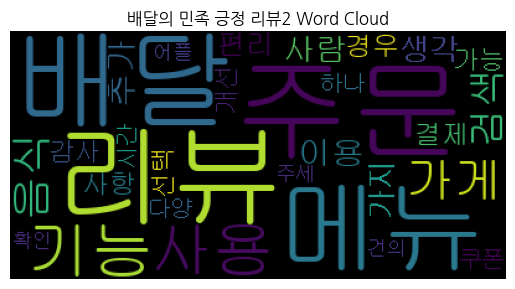

In [205]:
# "불편"을 포함하지 않는 긍정리뷰로 wordcloud 진행

sentence_word_list_p = list(reviews.loc[reviews["reaction"] == "P", "nouns"])
sentence_word_list_p2 = [s for s in sentence_word_list_p if "불편" not in s]
word_list_p2 = sum(sentence_word_list_p2, [])  # unpacking

print(len(word_list_p), len(word_list_p2))
print(word_list_p[:5], word_list_p2[:5])

counter_p2 = Counter(word_list_p2)
counter_p2_mc = dict(counter_p2.most_common(30))
print(counter_p2_mc)

wordcloud_p2 = WordCloud(
    font_path="C:/Windows/Fonts/NGULIM.TTF"
).generate_from_frequencies(counter_p2_mc)
plt.imshow(wordcloud_p2)
plt.title("배달의 민족 긍정 리뷰2 Word Cloud")
plt.axis('off')
plt.show()

#### 연관성 분석

In [199]:
from apyori import apriori

# sentence_word_list_p = list(reviews.loc[reviews["reaction"] == "P", "nouns"])
# sentence_word_list_n = list(reviews.loc[reviews["reaction"] == "N", "nouns"])
print(len(sentence_word_list_p), len(sentence_word_list_n), len(sentence_word_list_p2))



271 729 218


In [200]:
# 긍정 리뷰
apri_p = list(apriori(sentence_word_list_p, min_support=0.05))
df_apri_p = pd.DataFrame(apri_p)
print(df_apri_p.sort_values("support", ascending=False).head())

df_apri_p["length"] = [len(i) for i in df_apri_p["items"]]
# print(df_apri_p.tail())

df_apri_p = df_apri_p.loc[df_apri_p["length"] == 2]
print(df_apri_p.shape)
print(df_apri_p.sort_values("support").head())


   items   support                      ordered_statistics
13  (배달)  0.335793  [((), (배달), 0.33579335793357934, 1.0)]
11  (리뷰)  0.328413   [((), (리뷰), 0.3284132841328413, 1.0)]
30  (주문)  0.328413   [((), (주문), 0.3284132841328413, 1.0)]
9   (기능)  0.324723   [((), (기능), 0.3247232472324723, 1.0)]
12  (메뉴)  0.324723   [((), (메뉴), 0.3247232472324723, 1.0)]
(62, 4)
        items   support                                 ordered_statistics  \
49   (음식, 가게)  0.051661  [((), (음식, 가게), 0.05166051660516605, 1.0), ((가...   
52   (배달, 가지)  0.051661  [((), (가지, 배달), 0.05166051660516605, 1.0), ((가...   
69   (사람, 기능)  0.051661  [((), (사람, 기능), 0.05166051660516605, 1.0), ((기...   
62   (결제, 사용)  0.051661  [((), (결제, 사용), 0.05166051660516605, 1.0), ((결...   
103  (음식, 추가)  0.051661  [((), (음식, 추가), 0.05166051660516605, 1.0), ((음...   

     length  
49        2  
52        2  
69        2  
62        2  
103       2  


In [202]:
# 긍정 리뷰2
apri_p2 = list(apriori(sentence_word_list_p2, min_support=0.05))
df_apri_p2 = pd.DataFrame(apri_p2)
print(df_apri_p2.sort_values("support", ascending=False).head())

df_apri_p2["length"] = [len(i) for i in df_apri_p2["items"]]
# print(df_apri_p.tail())

df_apri_p2 = df_apri_p2.loc[df_apri_p2["length"] == 2]
print(df_apri_p2.shape)
print(df_apri_p2.sort_values("support").head())

   items   support                      ordered_statistics
14  (배달)  0.344037   [((), (배달), 0.3440366972477064, 1.0)]
29  (주문)  0.344037   [((), (주문), 0.3440366972477064, 1.0)]
12  (리뷰)  0.321101   [((), (리뷰), 0.3211009174311927, 1.0)]
13  (메뉴)  0.298165   [((), (메뉴), 0.2981651376146789, 1.0)]
9   (기능)  0.284404  [((), (기능), 0.28440366972477066, 1.0)]
(53, 4)
       items   support                                 ordered_statistics  \
46  (배달, 가지)  0.050459  [((), (가지, 배달), 0.05045871559633028, 1.0), ((가...   
50  (검색, 배달)  0.050459  [((), (검색, 배달), 0.05045871559633028, 1.0), ((검...   
52  (결제, 사용)  0.050459  [((), (결제, 사용), 0.05045871559633028, 1.0), ((결...   
55  (주문, 경우)  0.050459  [((), (주문, 경우), 0.05045871559633028, 1.0), ((경...   
60  (음식, 기능)  0.050459  [((), (음식, 기능), 0.05045871559633028, 1.0), ((기...   

    length  
46       2  
50       2  
52       2  
55       2  
60       2  


In [208]:
# 긍정 리뷰1에는 있으나 긍정 리뷰2에는 없는 아이템 확인
for p1 in list(df_apri_p["items"]):
    if p1 not in list(df_apri_p2["items"]):
        print(p1)

frozenset({'음식', '가게'})
frozenset({'추가', '가게'})
frozenset({'리뷰', '개선'})
frozenset({'메뉴', '개선'})
frozenset({'불편', '개선'})
frozenset({'불편', '검색'})
frozenset({'불편', '기능'})
frozenset({'사람', '기능'})
frozenset({'불편', '리뷰'})
frozenset({'불편', '메뉴'})
frozenset({'불편', '배달'})
frozenset({'불편', '사용'})
frozenset({'주문', '불편'})
frozenset({'추가', '불편'})
frozenset({'추가', '선택'})
frozenset({'음식', '추가'})


In [201]:
# 부정 리뷰
apri_n = list(apriori(sentence_word_list_n, min_support=0.05))
df_apri_n = pd.DataFrame(apri_n)
print(df_apri_n.sort_values("support", ascending=False).head())

df_apri_n["length"] = [len(i) for i in df_apri_n["items"]]
# print(df_apri_n.tail())

df_apri_n = df_apri_n.loc[df_apri_n["length"] == 2]
print(df_apri_n.shape)
print(df_apri_n.sort_values("support").head())

   items   support                      ordered_statistics
19  (배달)  0.399177   [((), (배달), 0.3991769547325103, 1.0)]
40  (주문)  0.344307   [((), (주문), 0.3443072702331962, 1.0)]
0   (가게)  0.193416   [((), (가게), 0.1934156378600823, 1.0)]
21  (불편)  0.179698  [((), (불편), 0.17969821673525377, 1.0)]
23  (사용)  0.159122  [((), (사용), 0.15912208504801098, 1.0)]
(31, 4)
       items   support                                 ordered_statistics  \
56  (주문, 고객)  0.050754  [((), (주문, 고객), 0.05075445816186557, 1.0), ((고...   
58  (주문, 기능)  0.050754  [((), (주문, 기능), 0.05075445816186557, 1.0), ((기...   
60  (배달, 리뷰)  0.050754  [((), (리뷰, 배달), 0.05075445816186557, 1.0), ((리...   
75  (음식, 주문)  0.050754  [((), (음식, 주문), 0.05075445816186557, 1.0), ((음...   
73  (쿠폰, 사용)  0.050754  [((), (쿠폰, 사용), 0.05075445816186557, 1.0), ((사...   

    length  
56       2  
58       2  
60       2  
75       2  
73       2  


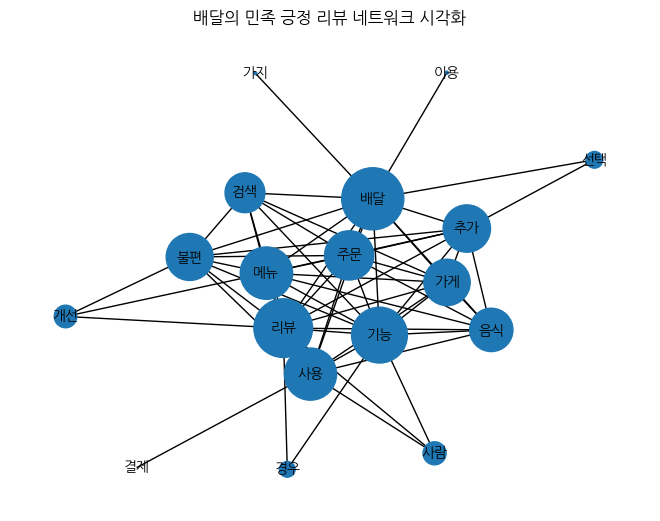

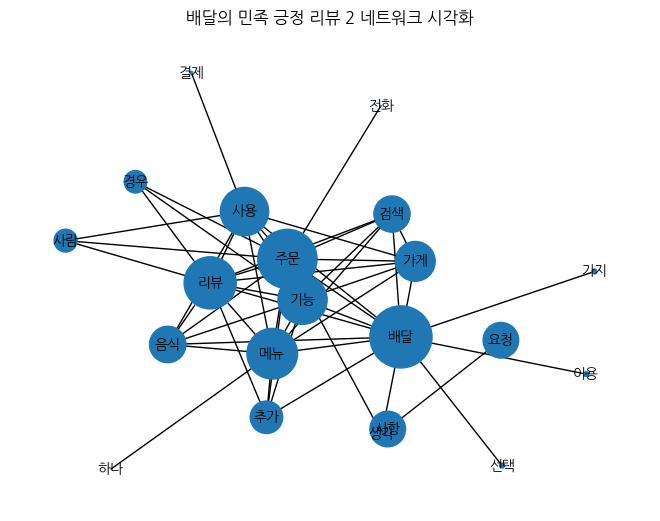

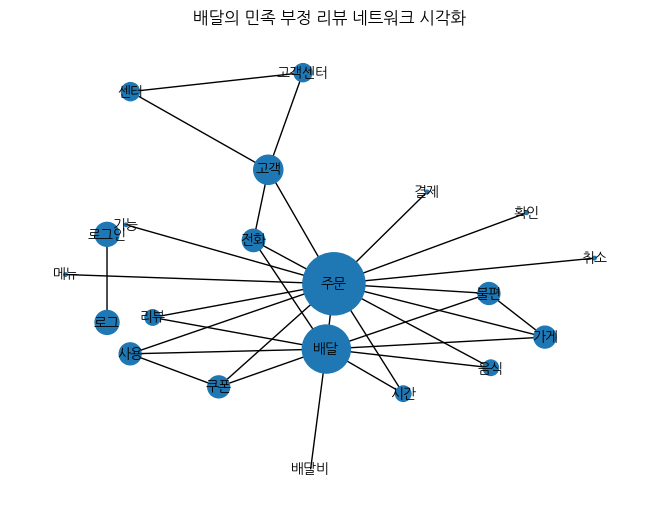

In [ ]:
# 네트워크 분석 시각화
import networkx as nx
import numpy as np
from matplotlib import pyplot as pyplot

plt.rc('font', family="NanumGothic")

# 긍정 리뷰1
G = nx.Graph()
ar_p = df_apri_p["items"]
G.add_edges_from(ar_p)

pr = nx.pagerank(G)
nsize = np.array(list(pr.values()))
nsize = 2000 * (nsize - min(nsize)) / (max(nsize) - min(nsize))

pos = nx.kamada_kawai_layout(G)

nx.draw(G, pos, node_size=nsize, with_labels=True, font_size=10, font_family="NanumGothic")
plt.title("배달의 민족 긍정 리뷰 네트워크 시각화")
plt.show()


# 긍정 리뷰2
G = nx.Graph()
ar_p2 = df_apri_p2["items"]
G.add_edges_from(ar_p2)

pr = nx.pagerank(G)
nsize = np.array(list(pr.values()))
nsize = 2000 * (nsize - min(nsize)) / (max(nsize) - min(nsize))

pos = nx.kamada_kawai_layout(G)

nx.draw(G, pos, node_size=nsize, with_labels=True, font_size=10, font_family="NanumGothic")
plt.title("배달의 민족 긍정 리뷰 2 네트워크 시각화")
plt.show()


# 부정 리뷰
G = nx.Graph()
ar_n = df_apri_n["items"]
G.add_edges_from(ar_n)

pr = nx.pagerank(G)
nsize = np.array(list(pr.values()))
nsize = 2000 * (nsize - min(nsize)) / (max(nsize) - min(nsize))

pos = nx.kamada_kawai_layout(G)

nx.draw(G, pos, node_size=nsize, with_labels=True, font_size=10, font_family="NanumGothic")
plt.title("배달의 민족 부정 리뷰 네트워크 시각화")
plt.show()


# 결론:
# 1. 긍정 리뷰의 경우 부정 리뷰에 비해 단어의 연관성이 복잡해보임 -> 긍정적인 점이 여러 개 일 수도 있으나, 그냥 평점을 높게 주는 사람들이 많을 수도 있어 보임
# 2. 부정 리뷰의 경우 주문 및 배달의 빈도가 높음
# 3. 주문 ~ 배달의 경우 긍정 리뷰와 부정 리뷰에서 모두 확인이 가능함 -> 평점을 높이기 위해 주문 ~ 배달에 신경써야 함
# 4. 네트워크 시각화 단계에서 support 점수의 가중치를 추가하는 방안 고려
# 5. 긍정 리뷰1과 긍정 리뷰2를 비교하였을 때, 긍정 리뷰2에서는 (음식, 추가) 및 (추가, 선택) 사이의 간선이 사라짐 -> 음식 추가 선택 관련 부정 리뷰 확인 필요

#### 댓글별 유사도

In [161]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

sentences = [
    "4~5만원 이상을 시켜야만 배달팁이 0원이고 실질적으로 3~6천원까지도 지불해야 하는 가게가 많습니다.",
    "1인 가구 특성상 과도한 배달비는 부담스러울 때가 있어요요",
    "정말로 최고의 배달앱입니다."
]

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(sentences)
# print(vectorizer.vocabulary_)
# print(tfidf_matrix.toarray())
# print(tfidf_matrix)

similarity = cosine_similarity(tfidf_matrix)
print(similarity)

# 해석: 전처리가 필요함

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
